In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math 
from ipywidgets import interact, interactive, fixed, interact_manual

from pyccapt.calibration_tools import tools, data_tools, variables, tof_calibration
from pyccapt.calibration_tools import widgets as wd
from pyccapt.mc import mc_tools

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # mm 
# The initial value for t_0
t0 = 51.74 # ns
variables.init()



In [2]:
number_sample = 300
save_fig=False
plot_fig=True 

$$\textbf{You can specify which dataset to use in below block}$$

In [3]:
variables.init()

tdc_model = 'surface_concept' # TDC model: surface_concept or roentdec

# dataset name
# dataset_name = 'AL_data_b'
dataset_name = 'OLO_AL_6_data'
# dataset_name = 'OLO_W_6_data'
# dataset_name = 'OLO_Ni_8_data'
# dataset_name = 'X6Cr17_2V30Min_5_data'
# dataset_name = "data_1029_Jun-27-2022_15-53_Pd"


p = path.abspath(path.join("", "../../../../.."))

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/tof_calibratin/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [4]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5257.555176,5257.555176,44526.0,631.203462,-11.715918,-8.882449
1,5257.555176,5257.555176,44633.0,627.863616,2.706122,9.996735
2,5257.555176,5257.555176,44745.0,623.165886,-4.329796,-3.151837
3,5257.555176,5257.555176,45014.0,648.355320,-29.385306,-12.384490
4,5257.555176,5257.555176,45080.0,628.885458,-13.817143,-6.972245
...,...,...,...,...,...,...
1893322,5710.601562,5710.601562,7225.0,609.086412,17.319184,-1.942041
1893323,5710.601562,5710.601562,7330.0,613.317798,16.650612,13.976327
1893324,5710.601562,5710.601562,7377.0,601.137990,11.429388,-1.942041
1893325,5710.601562,5710.601562,7532.0,626.869206,23.336327,27.793469


$\mathbf{\text{calculate the mc in two mode:}}$<br>

$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>

In [5]:
# t0
dld_t = dld_t - t0

In [6]:
# Remove negative and zero TOF
threshold = 70
dld_highVoltage = dld_highVoltage[dld_t>threshold]
dld_pulseVoltage = dld_pulseVoltage[dld_t>threshold]
dld_x = dld_x[dld_t>threshold]
dld_y = dld_y[dld_t>threshold]
dld_t = dld_t[dld_t>threshold]

<IPython.core.display.Javascript object>


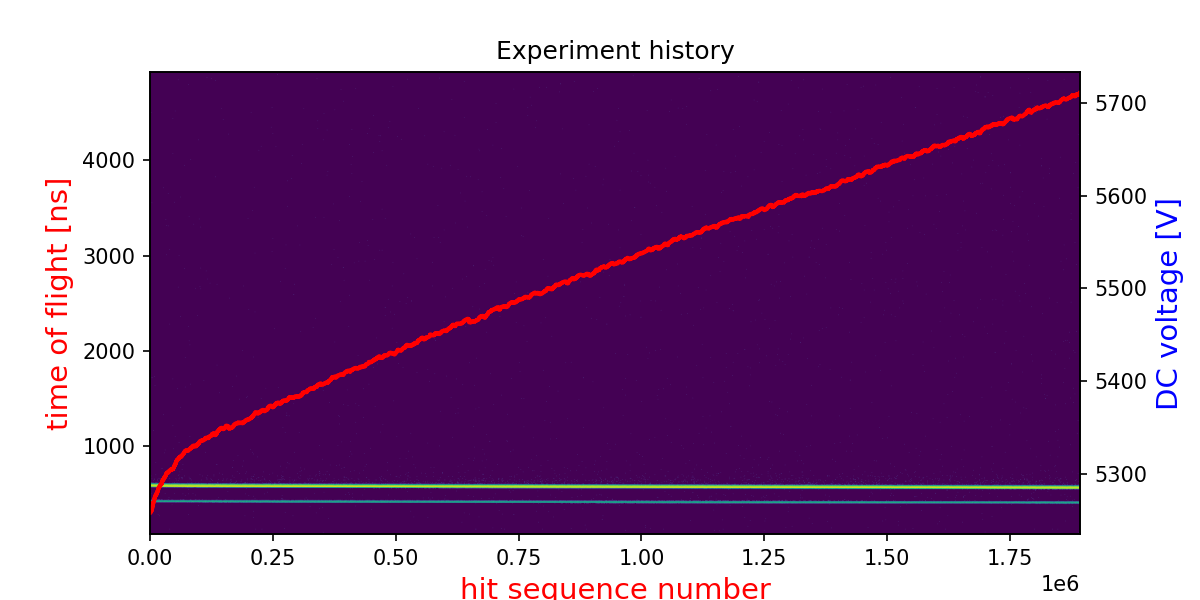

In [7]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

yaxis = dld_t[dld_t < 5000]  # dld_t
# y[y>5000] = 0
xaxis = np.arange(len(yaxis))
heatmap, xedges, yedges = np.histogram2d(xaxis, yaxis, bins=(1200, 800))
heatmap[heatmap == 0] = 1  # to have zero after apply log
heatmap = np.log(heatmap)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# set x-axis label
ax1.set_xlabel("hit sequence number", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("time of flight [ns]", color="red", fontsize=14)
plt.title("Experiment history")
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")

# plot high voltage curve
ax2 = ax1.twinx()

# dldGroupStorage[0] --> dld/high_voltage
high_voltage = dld_highVoltage[dld_t < 5000]
xaxis = np.arange(len(high_voltage))
ax2.plot(xaxis, high_voltage, color='r', linewidth=2)
ax2.set_ylabel("DC voltage [V]", color="blue", fontsize=14)
plt.show()

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

<IPython.core.display.Javascript object>


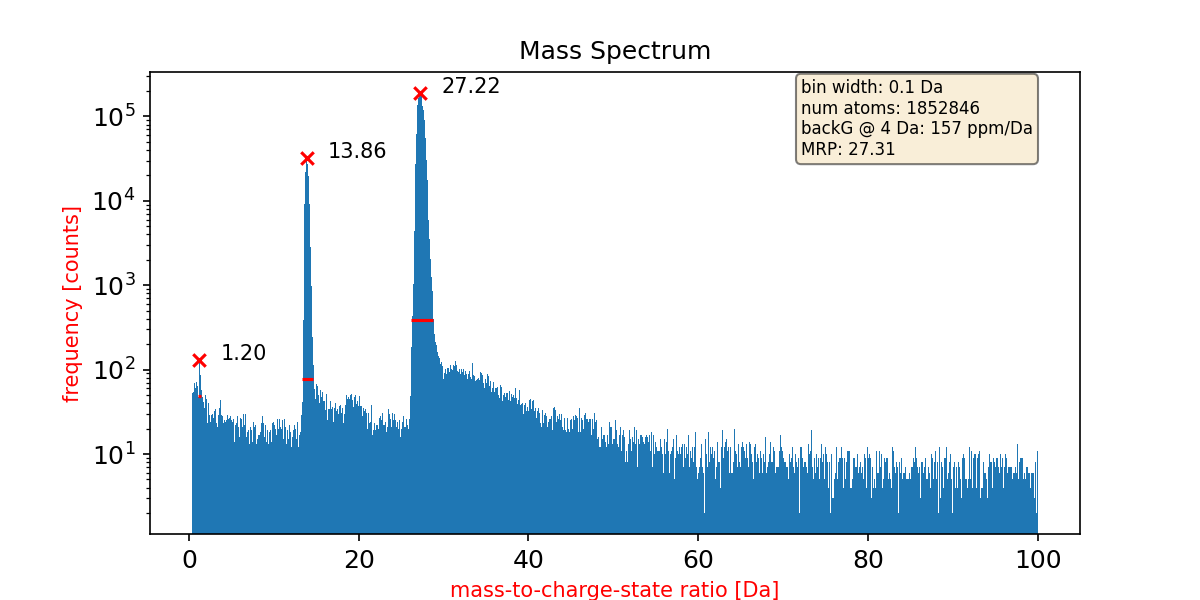

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [27.30531831]
Peaks  0 is: 1.20 peak window sides are: 1.10 - 1.40
Peaks  1 is: 13.86 peak window sides are: 13.56 - 14.16
Peaks  2 is: 27.22 peak window sides are: 26.72 - 27.72


In [8]:
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist_ini, left_right_peaks_ini, peaks_sides_ini, max_paek_edges_ini, index_max_ini = tools.massSpecPlot(mc_seb_ini[mc_seb_ini < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name=figname)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))

In [9]:
print('################ Before starting the calibration ################')
print('Maximum pick value:', max_hist_ini, 'right-left side of the peak:', left_right_peaks_ini)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))
print('#################################################################')

################ Before starting the calibration ################
Maximum pick value: [27.22075432] right-left side of the peak: [26.72230281 27.71920584]
Mass resolving power (MRP --> m/m_2-m_1): [27.30531831]
Peaks  0 is: 1.20 peak window sides are: 1.10 - 1.40
Peaks  1 is: 13.86 peak window sides are: 13.56 - 14.16
Peaks  2 is: 27.22 peak window sides are: 26.72 - 27.72
#################################################################


In [10]:
def user_selected_peak(peaks_sides, idx):
    peaks_chos = []
    peaks_chos.append(peaks_sides[idx, 0])
    peaks_chos.append(peaks_sides[idx, 2])
    peaks_chos.append(peaks_sides[idx, 3])
    return np.array(peaks_chos)

In [12]:
def tof_his(lim_dld_t, bin_size, prominence, distance, percent, plot=True, figname=figname, dld_t=dld_t):

    max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t[dld_t < lim_dld_t], bin_size, distance=distance, percent=percent, prominence=prominence, plot=plot, label='tof', fig_name=figname)
    mrp = (max_hist_tof / (left_right_peaks_tof[1] - left_right_peaks_tof[0]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_sides_tof)):
        print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof[i,2], peaks_sides_tof[i,3]))

In [ ]:
interact_manual(tof_his, lim_dld_t=[('1000',1000),('1500',1500)], bin_size = [('0.1', 0.1)] 
                ,prominence = [('10',10)], distance = [('1000',1000)], percent = [('50',50)]);


In [ ]:
idx_peak = variables.peaks_idx[0]
print('The selected peak index is:', idx_peak)


In [ ]:
i = 0
detector_squre = 2
dld_t_calib = np.copy(dld_t)
while True:
    index_fig = i
    max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1,  distance=1500, percent=50, prominence=8, plot=plot_fig, label='tof', fig_name=figname+'_%s' %i)
    mrp_tof = (max_hist_tof / (left_right_peaks_tof[1] - left_right_peaks_tof[0]))
    max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1,  distance=1500, percent=1, prominence=8, plot=plot_fig, label='tof')
    peaks_selected = user_selected_peak(peaks_sides_tof, idx_peak)
    
    if i==0:
        mask_temporal = np.logical_and((peaks_selected[1] < dld_t_calib), (dld_t_calib < peaks_selected[2] - 20))
    else:
        mask_temporal = np.logical_and((peaks_selected[1] < dld_t_calib), (dld_t_calib < peaks_selected[2]))
    dld_t_calib_v = dld_t_calib[mask_temporal]
    dld_x_peak_v = dld_x[mask_temporal]
    dld_y_peak_v = dld_y[mask_temporal]
    dld_highVoltage_peak_v = dld_highVoltage[mask_temporal]
    dld_pulseVoltage_peak_v = dld_pulseVoltage[mask_temporal]
    
    mask_spacial = np.logical_and((np.abs(dld_x_peak_v) < detector_squre), (np.abs(dld_y_peak_v) < detector_squre))
    
    dld_t_calib_v = dld_t_calib_v[mask_spacial]
    dld_x_peak_v = dld_x_peak_v[mask_spacial]
    dld_y_peak_v = dld_y_peak_v[mask_spacial]
    dld_highVoltage_peak_v = dld_highVoltage_peak_v[mask_spacial]
    dld_pulseVoltage_peak_v = dld_pulseVoltage_peak_v[mask_spacial]
    
    fitresult = tof_calibration.voltage_coorection(dld_highVoltage_peak_v, dld_t_calib_v, index_fig, figname, plot=plot_fig, save=save_fig, num_sample=number_sample)
    
    f_v = tof_calibration.voltage_corr(dld_highVoltage, *fitresult)
    dld_t_calib = dld_t_calib * f_v
    

    max_hist_tof_v, left_right_peaks_tof_v, peaks_sides_tof_v, max_paek_edges_tof_v, index_max_tof_v = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1, distance=1500, prominence=4, percent=50, plot=False, label='tof', fig_name='V_'+figname+'_%s' %i)
    mrp_v = (max_hist_tof_v / (left_right_peaks_tof_v[1] - left_right_peaks_tof_v[0]))
    max_hist_tof_v, left_right_peaks_tof_v, peaks_sides_tof_v, max_paek_edges_tof_v, index_max_tof_v = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1, distance=1500, prominence=4, percent=1, plot=True, label='tof')

    peaks_selected_v = user_selected_peak(peaks_sides_tof_v, idx_peak)
    
    mask_temporal_bowl = np.logical_and((peaks_selected_v[1] - 10 < dld_t_calib), (dld_t_calib < peaks_selected_v[2] + 20))

    dld_t_calib_bowl = dld_t_calib[mask_temporal_bowl]
    dld_x_peak_bowl = dld_x[mask_temporal_bowl]
    dld_y_peak_bowl = dld_y[mask_temporal_bowl]
    dld_highVoltage_peak_bowl = dld_highVoltage[mask_temporal_bowl]
    dld_pulseVoltage_peak_bowl = dld_pulseVoltage[mask_temporal_bowl]
    
    mask_bowl = np.logical_and((dld_highVoltage_peak_bowl), (dld_highVoltage_peak_bowl))
    
    dld_highVoltage_bowl = dld_highVoltage_peak_bowl[mask_bowl]
    dld_pulseVoltage_bowl = dld_pulseVoltage_peak_bowl[mask_bowl]
    dld_x_bowl = dld_x_peak_bowl[mask_bowl]
    dld_y_bowl = dld_y_peak_bowl[mask_bowl] 
    dld_t_calib_bowl = dld_t_calib_bowl[mask_bowl]
    

    
    #target_bowl = scaler1.fit_transform(target_bowl.reshape(-1, 1)).reshape((-1,)) 
    parameters = tof_calibration.bowl_correction(dld_x_bowl, dld_y_bowl, dld_t_calib_bowl, peaks_selected_v[0], index_fig, figname, plot=plot_fig, save=save_fig)

    scaler2 = MinMaxScaler(feature_range=(-1, 1))
    dld_x_norm = scaler2.fit_transform(dld_x.reshape(-1, 1)).reshape((-1,)) 
    dld_y_norm = scaler2.fit_transform(dld_y.reshape(-1, 1)).reshape((-1,)) 

    f_bowl = tof_calibration.bowl_corr_fit([dld_x_norm,dld_y_norm], *parameters)
    
    dld_t_calib = dld_t_calib * f_bowl
    
    max_hist_tof_bowl, left_right_peaks_tof_bowl, peaks_sides_tof_bowl, max_paek_edges_tof_bowl, index_max_tof_bowl = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1, distance=1500, prominence=8, percent=50, plot=True, label='tof', fig_name='bowl_'+figname+'_%s' %i)
    mrp_bowl = (max_hist_tof_bowl / (left_right_peaks_tof_bowl[1] - left_right_peaks_tof_bowl[0]))


    if i == 0:
        mrp_final = mrp_bowl
        dld_t_calib_final = np.copy(dld_t_calib)

    else:
        if mrp_final > mrp_bowl:
            print(f"mrp_previous: {mrp_final} - mrp_v: {mrp_v} - mrp_bowl: {mrp_bowl}")
            break
        else:
            print(f"mrp_previous: {mrp_final} - mrp_v: {mrp_v} - mrp_bowl: {mrp_bowl}")
            mrp_final = mrp_bowl
            dld_t_calib_final = np.copy(dld_t_calib)
    i = i + 1


In [ ]:
max_hist_tof_f, left_right_peaks_tof_f, peaks_sides_tof_f, max_paek_edges_tof_f, index_max_tof_f = tools.massSpecPlot(dld_t_calib_final[dld_t_calib_final < 1000], 0.1, distance=1500, prominence=8, percent=50, plot=True, label='tof', fig_name='bowl_'+figname)

In [ ]:
isotopeTableFile = '../../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList,elementIsotopeList,elementMassList,abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0],element[1],element[3]),element[2],)
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown)
display(chargeDropdown)
display(buttonAdd)
display(buttonDelete)
display(buttonReset)
listMaterial = buttonAdd.on_click(wd.onClickAdd)
buttonDelete.on_click(wd.onClickDelete)
buttonReset.on_click(wd.onClickReset)

In [ ]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(peaks_sides_tof_f[variables.peaks_idx[i],0])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(listMaterial)
print('highest peak in the mc histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', variables.listMaterial)

In [ ]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal)
    return fitresult

fitresult = parametric_calib(peaks_chos,  variables.listMaterial)


mc_p_1 = parametric(dld_t_calib_final, *fitresult)

In [ ]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_1[mc_p_1 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc2_p_1'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [ ]:
delta_t = interpolate.interp1d(peaks_chos, variables.listMaterial, kind='linear', fill_value="extrapolate")
mc_p_2 = delta_t(dld_t_calib_final)  


In [ ]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_2[mc_p_2 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc2_p_2'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [ ]:
# add calibrated tof and mc to hdf file
data_loadcrop.add_tof_mc_data_to_hdf5(filename, dld_t_calib_final, mc_p_1)